# Predicting Player Engagement Using Experience Levels with K-NN Regression


## **Introduction**
### Background
Running research studies that collect video game player data requires careful planning. In this project, a research team is studying player behaviour on a Minecraft server to better understand how players interact with the game over time. One important aspect of engagement is how many hours a player spends on the server. Knowing which players are likely to play more will help researchers estimate server demand, plan resources, and improve recruitment.

By building models that predict playtime based on player characteristics, researchers can forecast which types of players might generate more gameplay data. This will support decisions about server capacity, hardware needs, and recruitment priorities. In this project, I will explore whether a player’s experience level can help predict how many hours they will play using a K-Nearest Neighbors (K-NN) regression approach.


### The Research Question

The broad research question provided by the research team is:

> "Which kinds of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts?"

The specific research question I will answer is:

> "Can a player’s experience level be used to predict how many hours they will play on the Minecraft server?"

By answering this question, I aim to help the research team better understand which types of players are likely to spend more time playing. These insights could support server planning and recruitment of highly engaged players.

### Data Description

Before starting the analysis, we first need to load the necessary R packages that will allow us to work with the data.

- **tidyverse** — for data wrangling, reading files, cleaning variables, and visualizing data.
- **tidymodels** — for building and evaluating classification models later on



In [1]:
library(tidyverse) 
library(tidymodels) 
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Now that the packages are loaded, we can read in our dataset and begin exploring its structure. This will help us better understand the variables, the number of observations, and any potential issues before we build the model.

In [2]:
players_data<-read_csv("players (1).csv")
players_data

n_rows <- nrow(players_data)
n_cols <- ncol(players_data)
n_rows
n_cols


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


[1] 196

[1] 7

### Data Set Summary

The `players.csv` dataset contains information about 196 players and includes 7 columns. Below is a summary of the key variables.

#### 1. Variables Used

- `experience`: The player’s experience level, recorded as one of five categories: `Beginner`, `Amateur`, `Regular`, `Veteran`, or `Pro`. This will be used as the predictor in my analysis. I will convert this variable into numeric values so it can be used for regression modeling (as suggested by a TA).

- `played_hours`: The total number of hours each player has spent on the Minecraft server. This is the response variable I will try to predict.

#### 2. Other Variables in the Dataset (Not Used)

- `subscribe`: Whether the player subscribed to a game newsletter (`TRUE` or `FALSE`).
- `hashedEmail`: An anonymized ID for each player.
- `name`: The player’s first name.
- `gender`: The player’s gender.
- `Age`: The player’s age in years.

These variables are not used in the analysis.

#### 3. Rows and Columns

The dataset contains 196 observations and 7 columns.

#### 4. Data Issues

- Irrelevant variables (such as `name`, `email`, `gender`, `age`, and `subscribe`) were excluded.
- The data will be slightly wrangled and tidyed to make it easier to work with

## **Methods & Results**

### Data Wrangling

Now that we understand the structure of our dataset, we will first prepared the data for modeling.

Since our research question focuses on predicting `played_hours` using `experience`, we will only be keeping the variables needed for this analysis. The `experience` variable was originally a text category (`Beginner`, `Amateur`, `Regular`, `Veteran`, `Pro`), so we will convert it into numeric values (numbered 1–5) to use it as a predictor in the regression model. This suggestion was given to me by as TA, who reminded me that we can always turn chr into numerical values for models!

We will then select just the two variables we need:
- `exp_num`: the numeric version of experience (predictor)
- `played_hours`: total playtime (response variable)
 

In [3]:
players_data <- read_csv("players (1).csv", show_col_types = FALSE) %>%
  mutate(experience = factor(experience,
                             levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),),
         exp_num = as.numeric(experience))

knn_df <- players_data %>%
  select(exp_num, played_hours)
knn_df


exp_num,played_hours
<dbl>,<dbl>
5,30.3
4,3.8
4,0.0
⋮,⋮
2,0.0
2,2.3
5,0.2


### **Exploratory Visualization**

#### Part 1: Scatter Plot — Relationship Between Experience and Played Hours

Before building the model, I will first create a scatter plot to explore the relationship between player experience level and total played hours. This will help check for any patterns or trends between the predictor (`experience`) and the response variable (`played_hours`).


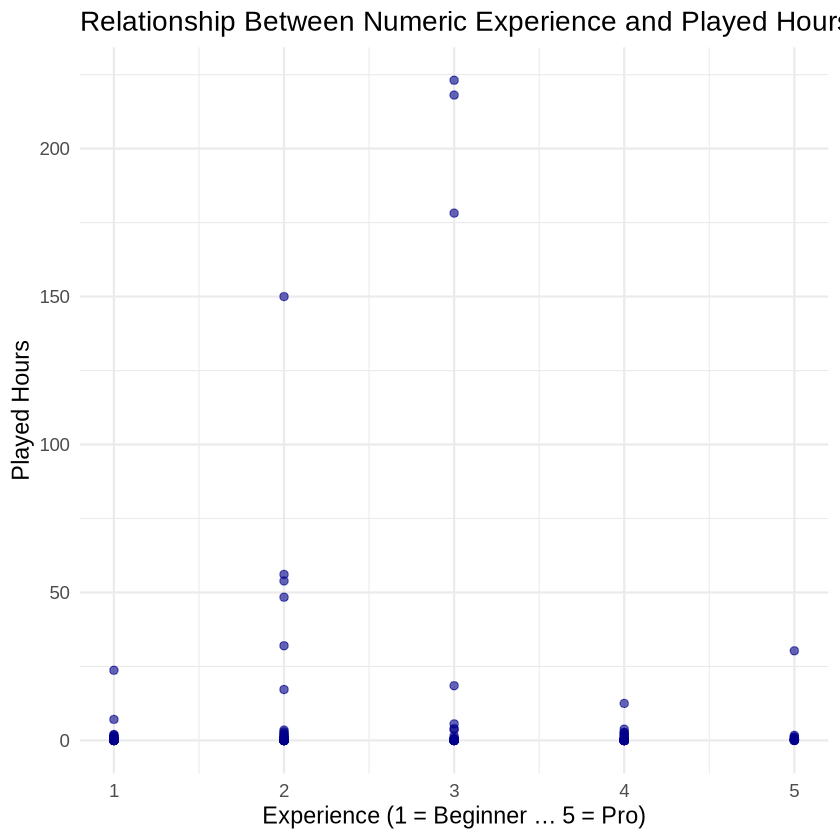

In [4]:
# Scatter plot of numeric experience vs played hours
players_data_plot <- ggplot(knn_df, aes(x = exp_num, y = played_hours)) +
  geom_point(alpha = 0.6, size = 2, color = "darkblue") +
  labs(x = "Experience (1 = Beginner … 5 = Pro)", y = "Played Hours",
    title = "Relationship Between Numeric Experience and Played Hours") +
  theme_minimal(base_size = 14)

players_data_plot

From the plot above, we can see that while a few player types have very high playtime values at certain experience levels, most players tend to have much lower total playtime, with many points close to zero. This suggests that the relationship between experience and played hours may not follow a perfectly linear pattern. This is important to keep in mind moving forward, especially as we build our model and come across any issues. 

#### Patterns Observed:

- Most players across all experience levels have low play hours.
- A small number of players, especially at some experience levels, have very high play hours.
- There is no simple or consistent trend where higher experience always leads to more played hours
- Overall, the data shows a lot of variability, which is common in real-world datasets.

#### Part 2: Histogram — Exploring the Overall Distribution of Played Hours

Before building the model, I will create a histogram to examine the distribution of `played_hours`. This plot is helpful because it shows how many players fall into different ranges of total hours played, giving us some insight into whether most players play for similar amounts of time or not. Since `played_hours` is a numerical variable and we want to see how often each range occurs, a histogram is more appropriate than a scatter plot.


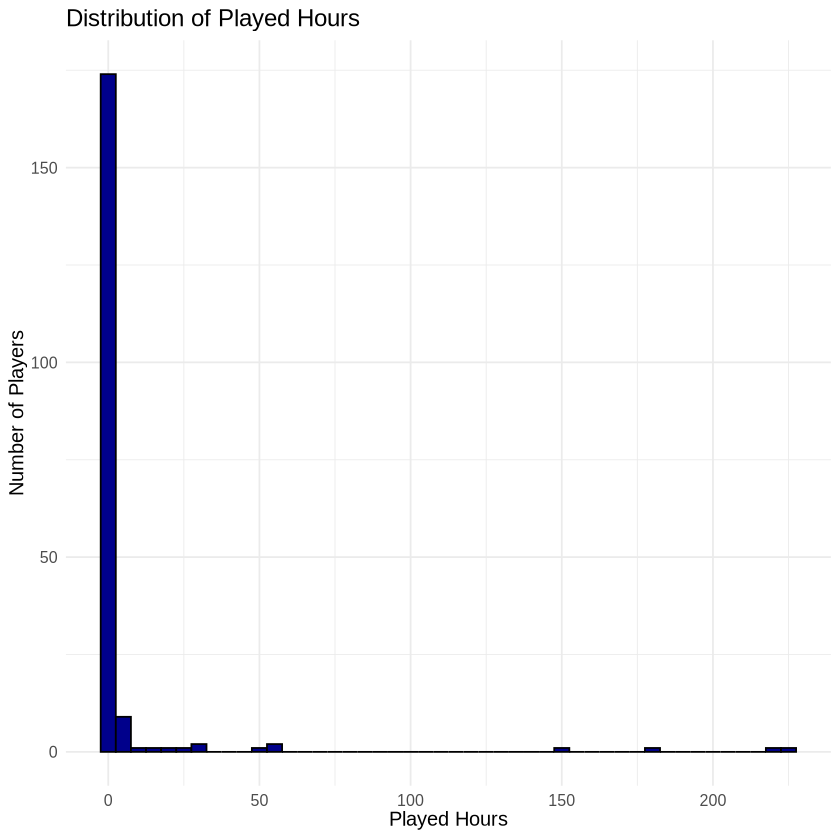

In [5]:
players_data_histogram <- players_data |>
  ggplot(aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "darkblue", color = "black") +
  labs(title = "Distribution of Played Hours", x = "Played Hours", y = "Number of Players") +
  theme_minimal() +
  theme(text = element_text(size = 12))
players_data_histogram

The histogram shows that most players have very low total played hours, while a few outliers play for very long periods. This highly skewed distribution suggests that experience level alone may not fully capture the variation in playtime. This is important to consider when building the model, as extreme values may make prediction more challenging.


### **Building the K-Nearest Neighbors (KNN) Model**
In this section, I build a KNN regression model to predict **played_hours** using **experience** as the predictor.

#### Step 1: Data Splitting & Preprocessing

I will start by splitting the data into training and testing sets. This allows me to evaluate how well the model performs on new, unseen data.

I will use 75% of the data for training and keep the remaining 25% for testing.



In [6]:
set.seed(2025)
players_split    <- initial_split(players_data, prop = 0.75)
players_train    <- training(players_split)
players_test     <- testing(players_split)

#### Step 2: Create Recipe and Model Specification

Now I will build a recipe to prepare the data for modeling. Since KNN relies on distance-based calculations, I will also center and scale all predictors to make sure they are on the same scale. This prevents one predictor from dominating the distance calculations.


In [7]:
players_recipe <- recipe(played_hours ~ exp_num, data = players_train) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

#### Step 3: Model Specification

Here, I set up the KNN regression model using the kknn engine. Since I don’t know the best value for **k** yet, I have left it open for tuning with the tune function. I will figure out the best **k** later on when I evaluate the model’s performance.


In [8]:
players_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = tune()) |>
set_engine("kknn") |>
set_mode("regression")

#### Step 4: Cross-validation Setup and Creating the Workflow and Tuning

Now I will set up 5-fold cross-validation on my training data. This lets me test how well different values of **k** perform without using the test set yet. I will also combine my recipe and model into one workflow.


In [9]:
players_wf <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

In [10]:
players_vfold <- vfold_cv(players_train, v = 5)

#### Step 6: Tune k

At this step, I run a grid search to try out different values of **k** from 1 to 50. For each **k**, cross-validation calculates performance using RMSE and R-squared. This helps me find out which value of **k** works best for my data.

In [11]:
grid_vals <- tibble(neighbors = seq(1, 50))

players_results <- players_wf |>
  tune_grid(resamples = players_vfold,
    grid      = grid_vals,
    metrics   = metric_set(rmse, rsq)) |>
  collect_metrics()

#### Step 7: Find the Best k

Now I select the value of **k** that gives the lowest RMSE from my grid search. This gives me the most accurate model based on my training data.

In [12]:
k_min <- players_results |>
  filter(.metric == "rmse") |>
  slice_min(mean, n = 1) |>
  pull(neighbors)
k_min

[1] 1

#### Step 8: Build and Fit the Final Model

Now that I have my best k value, I rebuild the model using that value. Then I fit this final model to my entire training data, which allows me to make predictions later on.


In [13]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
  set_engine("kknn") |>
  set_mode("regression")

players_best_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_best_spec)

players_best_fit <- players_best_workflow |>
  fit(data = players_train)


#### Step 9: Evaluate the Model on the Test Set

Now, I can test my final model on the test data to see how well it performs on unseen data. The main metrics I look at are RMSE (Root Mean Squared Error), R-squared (R²), and MAE (Mean Absolute Error). 


In [14]:
players_summary <- players_best_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred)

players_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,21.917954619
rsq,standard,0.009806458
mae,standard,4.048979592


From my results, the RMSE is around 21.92, the MAE is around 4.05, and the R² value is very low. This suggests that while my model can capture some patterns, it doesn't explain much of the variation in played hours, which may be due to the real-world variability in how people play.

#### Step 9.1: Visualizing Model Predictions for k = 1
Before making new predictions, I will visualize how well the model at k = 1 fits the training data.

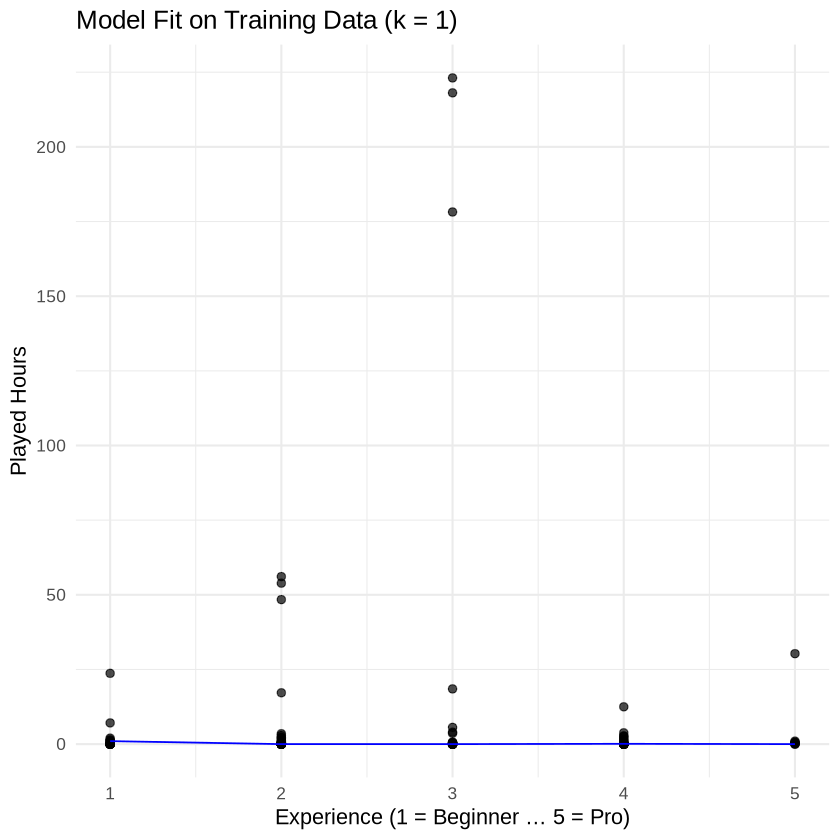

In [15]:
preds_k1 <- predict(players_best_fit, players_train) |> 
  bind_cols(players_train)

players_plot_k1 <- ggplot(preds_k1, aes(x = exp_num, y = played_hours)) +
  geom_point(alpha = 0.7, size = 2) +
  geom_line(aes(y = .pred), colour = "blue") +
  labs(
    x = "Experience (1 = Beginner … 5 = Pro)",
    y = "Played Hours",
    title = "Model Fit on Training Data (k = 1)"
  ) +
  theme_minimal(base_size = 13)

players_plot_k1

In this plot, we see that when k = 1, the model is essentially memorizing the training data. The blue prediction line sharply follows individual data points and reacts strongly to outliers. As a result, even small fluctuations in experience levels cause big jumps or drops in predicted playtime. This high sensitivity leads to overfitting and may be explaining why our model is predicting 0 hours.

#### Step 10: Create New Observations to Predict

Now that my model is trained, I will now prepare two new observations to test it. I will create two example players: one with **Regular** experience and one with **Pro** experience. I will also convert their experience levels into numeric values so that my model can make predictions on it.


In [16]:
# setting up a new observation

new_players <- tibble(experience = factor(c("Regular", "Pro"),
    levels  = c("Beginner","Amateur","Regular","Veteran","Pro"),
    ordered = TRUE)) |>
  mutate(exp_num = as.numeric(experience))

new_players

experience,exp_num
<ord>,<dbl>
Regular,3
Pro,5


In [17]:

new_preds <- players_best_fit |>
  predict(new_players) |>
  bind_cols(new_players)

new_preds

.pred,experience,exp_num
<dbl>,<ord>,<dbl>
0,Regular,3
0,Pro,5


As you can see, my model is predicting 0 hours for both the “Regular” and “Pro” players. This may be because the model was tuned to the absolute minimum RMSE, which happened when k = 1. Since k=1 simply takes the single closest neighbor, and that nearest neighbor likely had 0 played hours, the prediction also becomes 0.

To better understand why k=1 came up as the best choice, I will now look at and examine how RMSE changes as k increases. If RMSE stays fairly stable with slightly larger k values, it may make sense to use a larger k to avoid overly relying on just one data point.



#### Step 11: Visualizing RMSE Across Different k Values

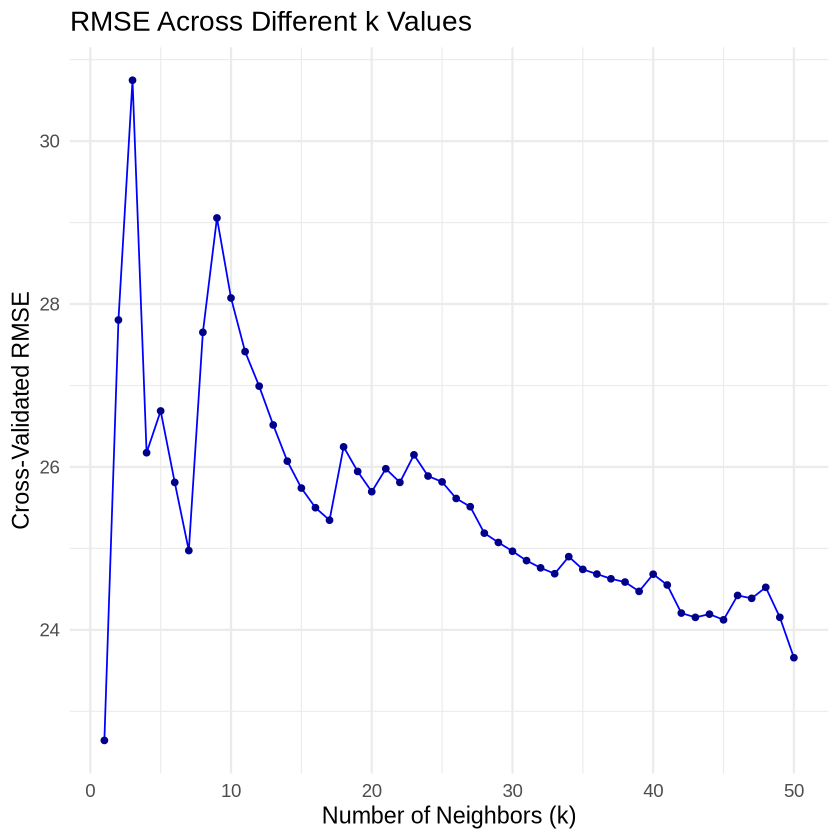

In [18]:
rmse_results <- players_results |>
  filter(.metric == "rmse")

rmse_plot <- ggplot(rmse_results, aes(x = neighbors, y = mean)) +
  geom_line(color = "blue") +
  geom_point(color = "darkblue") +
  labs(
    x = "Number of Neighbors (k)",
    y = "Cross-Validated RMSE",
    title = "RMSE Across Different k Values"
  ) +
  theme_minimal(base_size = 14)


rmse_plot

As we can see, the RMSE values from k = 1 up to around k = 10 are very noisy and bounce around a lot from different RMSE values. This may be one of the reasons why my model was earlier predicting 0 played hours — since small k-values often overfit to the few closest points, which sometimes happened to have 0 hours.

As mentioned in the project outlines, we can use external sources if it helps our model. Maulana & Roestam (2024) used an elbow method for tuning a k-nearest neighbors model when predicting voter turnout. They plotted model error across different k-values and selected a k where the error curve flattened out, instead of just picking the k that gave the absolute lowest error. This helped balance overfitting and underfitting.

Following a similar approach, I look at my own CV-RMSE vs. k plot and notice that after around k = 50, the curve created the sharpest point with the lowest RMSE. Rather than using k = 1 again, I will now test my model using k = 50. This may give a more stable and generalizable model that avoids the extreme predictions seen earlier.

#### Step 12: Build a New Model Using k = 50

Since k = 1 was causing zero-only predictions, I will now build a new KNN regression model using k = 50, which was selected based on the CV RMSE elbow point.


In [19]:
players50_spec <- nearest_neighbor(weight_func = "rectangular",neighbors   = 50) |>
  set_engine("kknn") |>
  set_mode("regression")

players50_wf <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players50_spec)

players50_fit <- players50_wf |>
  fit(data = players_train)

#### Step 12.1 Visualizing Model Predictions for k = 50
After updating the model with k = 50, I will again visualize the predictions on the training data. This allows me to see how using a larger k results in a smoother fit that avoids overfitting to single observations.

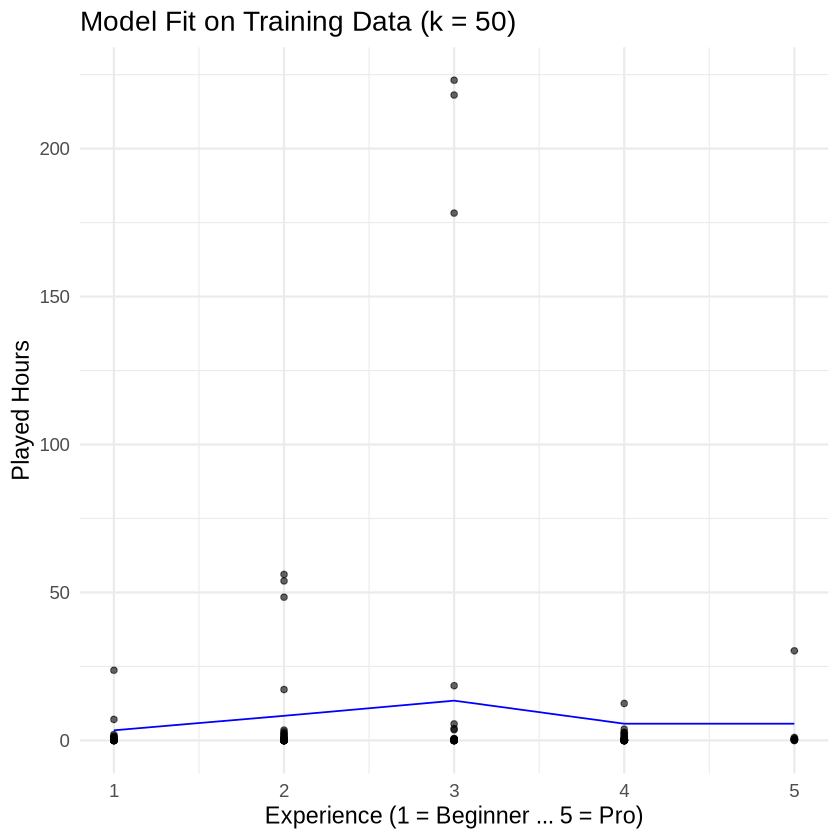

In [20]:
preds_k50 <- predict(players50_fit, players_train) |> 
  bind_cols(players_train)

players_plot_k50 <- ggplot(preds_k50, aes(x = exp_num, y = played_hours)) +
  geom_point(alpha = 0.6, color = "black") +
  geom_line(aes(y = .pred), color = "blue") +
  labs(
    x = "Experience (1 = Beginner ... 5 = Pro)",
    y = "Played Hours",
    title = "Model Fit on Training Data (k = 50)"
  ) +
  theme_minimal(base_size = 14)


players_plot_k50

Compared to k=1, the model with k=50 no longer overfits to the extreme values and produces a smoother fit. This allows it to generalize slightly better and make more reasonable predictions.

#### Step 12: Evaluate the Model with k = 50

Now I can evaluate how the model performs on the test data using the updated k value.

In [21]:

players50_summary <- players50_fit |>
  predict(players_test) |>
  bind_cols(players_test) |>
  metrics(truth = played_hours, estimate = .pred)

players_summary
players50_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,21.917954619
rsq,standard,0.009806458
mae,standard,4.048979592


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,21.835728367
rsq,standard,0.003539717
mae,standard,9.970693878


As you can see, I have also summoned the players_summary for k = 1 for comparison's sake. Let's compare k = 1 with k = 50. When k = 1, the RMSE was about 21.92. After switching to k = 50, the RMSE decreased slightly to 21.83. his difference is very small, but using k = 50 helps avoid overfitting and gives a more generalizable model.

#### Step 13: Make Predictions Using the Final Model
Now that the model is trained using k = 50, we use it to predict the number of played hours for two new players: one with “Regular” experience and one with “Pro” experience.

In [22]:
players50_preds <- players50_fit |>
  predict(new_players) |>
  bind_cols(new_players)

players50_preds

.pred,experience,exp_num
<dbl>,<ord>,<dbl>
13.442,Regular,3
5.648,Pro,5


After switching to k = 50, the model now predicts 13.4 hours for a Regular player and 5.6 hours for a Pro player. This is a noticeable improvement from before, where the model predicted 0 hours for both. These predictions still may not be perfectly accurate, but they are more reasonable and reflect some variation based on experience level. This suggests that using a higher k helps the model generalize better rather than just memorizing its nearest neighbor.

### **Discussion**

#### Why did I choose to use a K-nearest Neighbours regression model? Why is this method appropriate?

I chose K-nearest Neighbours (K-NN) regression because my response variable, `played_hours`, is numeric, and my goal is to predict how many hours a player might play based on their experience level. Regression is appropriate when the outcome we're predicting is a number, not a category.

K-NN regression is a good fit for this problem because it makes very few assumptions about the relationship between experience and playtime. Instead of assuming the data into a straight line (like linear regression does), K-NN predicts values based on the average of the closest data points (neighbors). This allows it to work well even if the relationship between experience and playtime isn’t perfectly linear, which is something I observed in my data exploration.

Also, the K-NN approach is fairly simple and easy to understand: the model looks at players with similar experience levels to make a prediction. Since my dataset is not very large and the relationship may be non-linear, K-NN regression provides a flexible option that can adapt to patterns in the data.


#### What assumptions are required to apply the K-nearest Neighbours regression model?

K-NN regression has fewer assumptions compared to some other models, but there are still some important things to keep in mind when using this model.

- **Similarity matters:** The algorithm assumes that observations that are close to each other in predictor space will have similar response values. This means that players with similar experience levels are assumed to have similar played hours.
- **Appropriate scaling:** Because K-NN uses distance to determine neighbors, it assumes that all predictors are on a similar scale.
- **Sufficient data density:** The method works best when there are enough data points across the range of the predictor
- **Predictors are meaningful:** The predictors used must have some relationship to the response variable. If the predictors have no relationship to `played_hours`, then even the nearest neighbors won’t provide helpful information

#### What are the potential limitations or weaknesses of the method selected?

K-NN regression has a few weaknesses. It can struggle if the dataset gets much larger because it needs to calculate distances for every prediction. It also doesn't work well when there are many predictor variables, or when we need to make predictions far outside the range of the training data. Finally, choosing the right k value can be tricky and sensitive to noise in the data.



#### What did I learn from making this model from start to finish?

From picking predictors to choosing the model type and wrangling the data, I’ve learned that building an effective model requires thoughtful decisions at every step. At first, my model predicted with k = 1, but after re-evaluating, I realized that this likely happened because of a very weak relationship between experience and played hours (which was something I noticed through my exploratory visualizations). As a result, the model relied too heavily on just one neighbor when making predictions.

When I wasn’t sure how to improve it, I looked for alternative methods and explored how RMSE changed with different k values. This led me to the work of Maulana and Roestam, whose approach helped me identify a better k.

This showed me that making accurate models requires not just coding and memorizing steps, but also critical thinking, exploration, and reflection on what the data is really telling us. 

#### **Final Remarks**
In this project, I used K-nearest Neighbors (K-NN) regression to predict how many hours a player might spend playing based on their experience level. My final model with k=50 predicted 13.4 hours for a Regular player and 5.6 hours for a Pro player. This was an improvement over my earlier result with k=1, where the model predicted 0 hours for both new observations. Increasing k allowed the model to make more reasonable predictions.

These results partly matched what I expected. Since experience level is related to playtime, I anticipated seeing some relationship between these variables, but I also knew the connection might not be perfectly strong or linear. The low R² value that we saw earlier confirmed that experience level alone does not fully explain how long players play. Other factors likely play a role, such as motivation, available time to play, or personal interest in the game (these variables were not captured in the data set).

In the future, it may be useful to explore multivariable K-NN regression or compare K-NN to other algorithms like linear regression. These models may better capture the complex patterns behind player behaviour.

Lastly, I’ve learned that realistically, what seems like a strong predictor might not actually work well in practice. Just because a variable makes sense intuitively doesn’t mean it will perform well when predicting outcomes. It’s important to listen to what the data is telling you and to test different or better predictors to avoid the kinds of issues I ran into. If I were to try again, I would do more exploratory visualizations and adjust my predictors (and possibly include more than one) to make a better model.  

### **References**

Maulana, I., & Roestam, R. (2024). Optimizing KNN algorithm using Elbow method for predicting voter participation using fixed Voter list data (DPT). Jurnal Sosial Teknologi, 4(7), 441–451. https://doi.org/10.59188/jurnalsostech.v4i7.1308
